In [42]:
COLORS = {
    'header': '\033[95m',
    'blue': '\033[94m',
    'cyan': '\033[96m',
    'green': '\033[92m',
    'warning': '\033[93m',
    'fail': '\033[91m',
    'endc': '\033[0m',
    'bold': '\033[1m',
    'underline': '\033[4m'
}

def color_text(text: str, color: str) -> str:
    return f"{COLORS.get(color, COLORS['endc'])}{text}{COLORS['endc']}"


# 🎯 Our Benchmarking Goals:

We want three benchmark modes:

## 1️⃣ Single-object benchmark

> Test the speed of instantiate / encode / decode on ONE user, repeated many times (e.g. 100k iterations).

* ✔ Gives us the pure speed of each framework.

## 2️⃣ Multi-object benchmark

> Test performance on a batch of different users (e.g. 1000 or 10,000 users) processed once.

* ✔ Gives us throughput and scaling behavior.

## 3️⃣ Visual summary

Create a plot like with:
  * bars for encode
  * bars for decode
  * bars for total

## ⭐ PART 1 — Import Benchmark Functions:

In [43]:
from benchmark_dataclass import instantiate_dataclass, encode_dataclass, decode_dataclass
from benchmark_pydantic import instantiate_pydantic, encode_pydantic, decode_pydantic
from benchmark_msgspec import instantiate_msgspec, encode_msgspec, decode_msgspec
from data_generator import generate_users_batch

from time import perf_counter
import statistics



## ⭐ PART 2 — Microbenchmark Helper:

* We will measure the `SAME ITEM` repeated many times.

In [59]:
from typing import Dict, Callable

def micro_benchmark(fn: Callable, obj: Dict | None, iterations: int = 1_000) -> float:
    times = []
    for _ in range(iterations):
        start = perf_counter()
        fn(obj)
        end = perf_counter()
        times.append(end - start)

    return statistics.mean(times) * 1e6


✔ **Purpose**:
  * Measure pure function cost;
  * Very stable (many repetitions);
  * Used by msgspec vs pydantic authors as well.
  

## ⭐ PART 3 — Batch Benchmark Helper:

* We will measure `MANY DIFFERENT ITEMS` processed once.


In [60]:
from typing import Any, Dict, List, Tuple, Callable

def batch_benchmark(fn: Callable, batch: List[Dict]) -> Tuple[float, float]:
    start = perf_counter()
    for item in batch:
        fn(item)
    end = perf_counter()
    total = end - start
    avg_us = (total / len(batch)) * 1e6
    return avg_us, total
    

✔ **Purpose**:
  * Measures throughput on real workload;
  * Per-item time and total time.

## ⭐ PART 4 — RUN MICROBENCHMARK (single user)

In [61]:
batch_size = 1
iterations_micro_banchmark = 10_000
generated_data = generate_users_batch(batch_size=batch_size)

single_user = generated_data[0]

# Instantiate objects:
dc_obj = instantiate_dataclass(single_user)
py_obj = instantiate_pydantic(single_user)
ms_obj = instantiate_msgspec(single_user)

# Encode once:
dc_encoded = encode_dataclass(dc_obj)
py_encoded = encode_pydantic(py_obj)
ms_encoded = encode_msgspec(ms_obj)

# Decode once:
dc_decoded = decode_dataclass(dc_encoded)
py_decoded = decode_pydantic(py_encoded)
ms_decoded = decode_msgspec(ms_encoded)


dc_instantiated_banchmark = micro_benchmark(instantiate_dataclass, single_user, iterations=iterations_micro_banchmark)
py_instantiated_banchmark = micro_benchmark(instantiate_pydantic, single_user, iterations=iterations_micro_banchmark)
ms_instantiated_banchmark = micro_benchmark(instantiate_msgspec, single_user, iterations=iterations_micro_banchmark)

dc_encoded_banchmark = micro_benchmark(lambda _: encode_dataclass(dc_obj), None, iterations=iterations_micro_banchmark)
py_encoded_banchmark = micro_benchmark(lambda _: encode_pydantic(py_obj), None, iterations=iterations_micro_banchmark)
ms_encoded_banchmark = micro_benchmark(lambda _: encode_msgspec(ms_obj), None, iterations=iterations_micro_banchmark)

dc_decoded_banchmark = micro_benchmark(lambda _: decode_dataclass(dc_encoded), None, iterations=iterations_micro_banchmark)
py_decoded_banchmark = micro_benchmark(lambda _: decode_pydantic(py_encoded), None, iterations=iterations_micro_banchmark)
ms_decoded_banchmark = micro_benchmark(lambda _: decode_msgspec(ms_encoded), None, iterations=iterations_micro_banchmark)


print("=============== Microbenchmark: single-object repeated ===============\n")
print(f"Dataclass: {color_text('instantiate', 'warning')} = {color_text(f'{dc_instantiated_banchmark:.2f}', 'fail')} µs | {color_text('encode', 'warning')} = {color_text(f'{dc_encoded_banchmark:.2f}', 'fail')} µs | {color_text('decode', 'warning')} = {color_text(f'{dc_decoded_banchmark:.2f}', 'fail')} µs")
print(f"Pydantic:  {color_text('instantiate', 'warning')} = {color_text(f'{py_instantiated_banchmark:.2f}', 'fail')} µs | {color_text('encode', 'warning')} = {color_text(f'{py_encoded_banchmark:.2f}', 'fail')} µs | {color_text('decode', 'warning')} = {color_text(f'{py_decoded_banchmark:.2f}', 'fail')} µs")
print(f"Msgspec:   {color_text('instantiate', 'warning')} = {color_text(f'{ms_instantiated_banchmark:.2f}', 'fail')} µs | {color_text('encode', 'warning')} = {color_text(f'{ms_encoded_banchmark:.2f}', 'fail')} µs | {color_text('decode', 'warning')} = {color_text(f'{ms_decoded_banchmark:.2f}', 'fail')} µs")
print("\n=======================================================================")


=============== Microbenchmark: single-object repeated ===============

Dataclass: instantiate = 0.26 µs | encode = 5.55 µs | decode = 1.60 µs
Pydantic:  instantiate = 0.91 µs | encode = 0.78 µs | decode = 0.99 µs
Msgspec:   instantiate = 0.19 µs | encode = 0.15 µs | decode = 0.25 µs



## ⭐ PART 5 — RUN BATCH BENCHMARK (1000 different users)


In [62]:

start = perf_counter()

batch_size = 1_000_000
users = generate_users_batch(batch_size)

# Prepare encoded objects for decoding benchmark
dc_objs = [instantiate_dataclass(user) for user in users]
py_objs = [instantiate_pydantic(user) for user in users]
ms_objs = [instantiate_msgspec(user) for user in users]

# Prepare encoded data for decoding benchmark
dc_encoded_batch = [encode_dataclass(obj) for obj in dc_objs]
py_encoded_batch = [encode_pydantic(obj) for obj in py_objs]
ms_encoded_batch = [encode_msgspec(obj) for obj in ms_objs]

print("=============== Batch benchmark: many different objects ===============\n")

# Instantiation benchmark:
dc_instantiated_avg, dc_instantiated_total = batch_benchmark(instantiate_dataclass, users)
py_instantiated_avg, py_instantiated_total = batch_benchmark(instantiate_pydantic, users)
ms_instantiated_avg, ms_instantiated_total = batch_benchmark(instantiate_msgspec, users)

print(f"Dataclass: {color_text('instantiate', 'warning')} = {color_text(f'{dc_instantiated_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{dc_instantiated_total:.6f}', 'fail')} s")
print(f"Pydantic:  {color_text('instantiate', 'warning')} = {color_text(f'{py_instantiated_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{py_instantiated_total:.6f}', 'fail')} s")
print(f"Msgspec:   {color_text('instantiate', 'warning')} = {color_text(f'{ms_instantiated_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{ms_instantiated_total:.6f}', 'fail')} s")
print("-----------------------------------------------------------------------")

# Encoding benchmark:
dc_encoded_avg, dc_encoded_total = batch_benchmark(encode_dataclass, dc_objs)
py_encoded_avg, py_encoded_total = batch_benchmark(encode_pydantic, py_objs)
ms_encoded_avg, ms_encoded_total = batch_benchmark(encode_msgspec, ms_objs) 

print(f"Dataclass: {color_text('encode', 'warning')} = {color_text(f'{dc_encoded_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{dc_encoded_total:.6f}', 'fail')} s")
print(f"Pydantic:  {color_text('encode', 'warning')} = {color_text(f'{py_encoded_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{py_encoded_total:.6f}', 'fail')} s")
print(f"Msgspec:   {color_text('encode', 'warning')} = {color_text(f'{ms_encoded_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{ms_encoded_total:.6f}', 'fail')} s")
print("-----------------------------------------------------------------------")

# Decoding benchmark:
dc_decoded_avg, dc_decoded_total = batch_benchmark(decode_dataclass, dc_encoded_batch)
py_decoded_avg, py_decoded_total = batch_benchmark(decode_pydantic, py_encoded_batch)
ms_decoded_avg, ms_decoded_total = batch_benchmark(decode_msgspec, ms_encoded_batch)    

print(f"Dataclass: {color_text('decode', 'warning')} = {color_text(f'{dc_decoded_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{dc_decoded_total:.6f}', 'fail')} s")
print(f"Pydantic:  {color_text('decode', 'warning')} = {color_text(f'{py_decoded_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{py_decoded_total:.6f}', 'fail')} s")
print(f"Msgspec:   {color_text('decode', 'warning')} = {color_text(f'{ms_decoded_avg:.2f}', 'fail')} µs/item | {color_text('total', 'warning')} = {color_text(f'{ms_decoded_total:.6f}', 'fail')} s")
print("\n=======================================================================")  

end = perf_counter()
total_time = end - start

print(f"\n{color_text('Total benchmarking time:', 'bold')} {color_text(f'{total_time:.6f} seconds', 'green')}")

=============== Batch benchmark: many different objects ===============

Dataclass: instantiate = 0.22 µs/item | total = 0.216085 s
Pydantic:  instantiate = 0.78 µs/item | total = 0.779388 s
Msgspec:   instantiate = 0.15 µs/item | total = 0.154950 s
-----------------------------------------------------------------------
Dataclass: encode = 2.95 µs/item | total = 2.954271 s
Pydantic:  encode = 0.80 µs/item | total = 0.799908 s
Msgspec:   encode = 0.12 µs/item | total = 0.122657 s
-----------------------------------------------------------------------
Dataclass: decode = 1.56 µs/item | total = 1.564366 s
Pydantic:  decode = 0.99 µs/item | total = 0.992064 s
Msgspec:   decode = 0.22 µs/item | total = 0.221763 s


Total benchmarking time: 16.929767 seconds


In [57]:
0.206466 + 0.766926 + 0.142240 + 2.955118 + 0.789540 + 0.121414 + 1.580646 + 0.942882 + 0.208861 

7.714092999999999

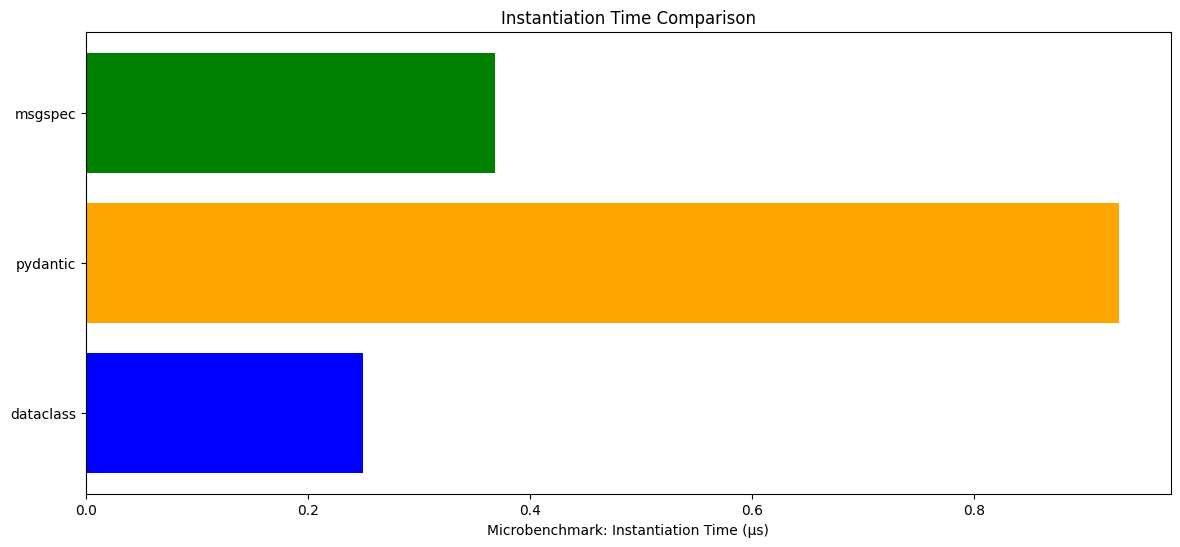

In [49]:
import matplotlib.pyplot as plt


labels = ['dataclass', 'pydantic', 'msgspec']

plt.figure(figsize=(14,6))
plt.barh(labels, [
    dc_instantiated_banchmark,
    py_instantiated_banchmark,
    ms_instantiated_banchmark
], color=['blue', 'orange', 'green'])

plt.xlabel('Microbenchmark: Instantiation Time (µs)')
plt.title('Instantiation Time Comparison')
plt.show()